In [210]:
import pandas as pd
dataOld = pd.read_csv("bigfu.csv", sep =';')
dataOld = dataOld.drop(['BenutzerNr', 'FahrzeugNr', 'Strecke', 'KraftstoffNr',  \
                  'Kraftstoff', 'Notiz', 'Verbrauch', 'Sparsam', \
                  'Normal', 'Schnell', 'Winter', 'Sommer', 'Ganzjahr', \
                  'Stadt', 'Land', 'Autobahn', 'Klima', 'Anhaenger'], axis=1)
dataOld.head()

,ArtNr,Datum,Laufleistung,Tankmenge,Kosten
0,2,2018-05-02,161152,"20,91","25,07"
1,1,2018-04-19,160309,"39,18","45,80"
2,1,2018-04-12,159559,"37,11","43,75"
3,1,2018-04-01,158783,"25,05","29,28"
4,1,2018-03-28,158231,"45,81","52,64"


In [211]:
dataNew = pd.read_csv("bigfuNew.csv", sep = r'\t', engine='python')
data = pd.concat([dataOld, dataNew])
ordData = data.sort_values(by='Datum')
carInfo = pd.DataFrame(ordData)
carInfo['Datum'] = pd.to_datetime(carInfo.Datum)
carInfo['Tankmenge'] = pd.to_numeric(carInfo.Tankmenge.apply(lambda x: x.replace(',','.')))
carInfo['Kosten'] = pd.to_numeric(carInfo.Kosten.apply(lambda x: x.replace(',','.')))
carInfo['Price'] = (carInfo.Kosten/carInfo.Tankmenge).round(3)
# tank = pd.to_numeric(ordData.Tankmenge.apply(lambda x: x.replace(',','.')))
# kosten = pd.to_numeric(ordData.Kosten.apply(lambda x: x.replace(',','.')))
carInfo = carInfo.set_index('Datum')

dist = []
[dist.append(carInfo.Laufleistung[i+1] - carInfo.Laufleistung[i]) for i in range(0, len(carInfo)-1)]
dist.insert(0,0) # Erstbetankung
carInfo['Distance'] = dist

In [212]:
d2016 = pd.datetime(2016,1,1)
d2017 = pd.datetime(2017,1,1)
d2018 = pd.datetime(2018,1,1)
d2019 = pd.datetime(2019,1,1)
carInfo.head()

,ArtNr,Laufleistung,Tankmenge,Kosten,Price,Distance
Datum,,,,,,
2016-01-29,3,107480,40.27,38.22,0.949,0
2016-02-08,1,108190,37.99,36.05,0.949,710
2016-02-18,1,109040,42.13,39.14,0.929,850
2016-02-25,1,109839,43.47,40.82,0.939,799
2016-03-04,1,110400,27.71,27.96,1.009,561


In [348]:
idx = [i for i in range(0, len(carInfo)) if carInfo.ArtNr[i] == 2] # get index of the not fully fuelled records
idxp1 = [item + 1 for item in idx]
odate = carInfo[carInfo.ArtNr != 1].index
date = carInfo.Tankmenge.iloc[idxp1].index
nT = [(carInfo.Tankmenge.iloc[i] + carInfo.Tankmenge.iloc[i+1]).round(2) for i in idx]
nD = [(carInfo.Distance.iloc[i] + carInfo.Distance.iloc[i+1]) for i in idx]
Lper100temp = carInfo.drop(['ArtNr', 'Laufleistung', 'Kosten', 'Price'], axis = 1)
for i in range(0, len(date)):
    Lper100temp.at[date[i], 'Tankmenge'] = nT[i]
    Lper100temp.at[date[i], 'Distance'] = nD[i]
Lper100 = Lper100temp.drop(odate)
Lper100['Consumption'] = (Lper100.Tankmenge/Lper100.Distance*100).round(2)
carInfo[d2018:d2019]

/home/gong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,ArtNr,Laufleistung,Tankmenge,Kosten,Price,Distance
Datum,,,,,,
2018-01-10,1,153425,42.61,49.81,1.169,815
2018-01-23,1,153875,23.87,27.19,1.139,450
2018-02-02,1,154284,21.15,24.09,1.139,409
2018-02-07,1,154744,22.29,25.39,1.139,460
2018-02-19,1,155498,38.63,42.45,1.099,754
2018-03-04,1,155956,26.12,29.76,1.139,458
2018-03-06,1,156605,34.57,38.68,1.119,649
2018-03-20,1,156987,20.21,22.61,1.119,382
2018-03-27,2,157746,20.19,24.41,1.209,759


In [327]:
import matplotlib.pyplot as plt
%matplotlib inline

,Tankmenge,Distance,Consumption
Datum,,,
2018-01-10,42.61,815,5.23
2018-01-23,23.87,450,5.30
2018-02-02,21.15,409,5.17
2018-02-07,22.29,460,4.85
2018-02-19,38.63,754,5.12
2018-03-04,26.12,458,5.70
2018-03-06,34.57,649,5.33
2018-03-20,20.21,382,5.29
2018-03-28,66.00,1244,5.31


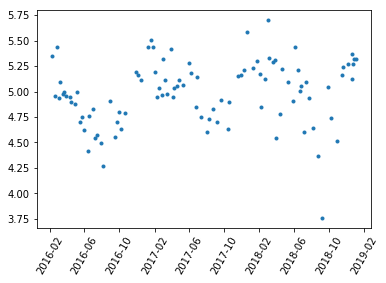

In [349]:
fig, ax = plt.subplots(facecolor=(1, 1, 1))
plt.plot(Lper100.index, Lper100.Consumption, '.')
ax.xaxis_date()
plt.xticks(rotation=60)
Lper100[d2018:d2019]